# (논문) STUDY
> Cat/Dog_accuracy / 이미지 위에 그림 그리기

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

## **전체 이미지를 대상으로 $\theta$를 바꿔가며 accuracy 변화를 확인하자**

### import 

In [1]:
import torch 
from fastai.vision.all import *
import cv2

In [2]:
import numpy as np

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

---

### data 

In [44]:
path=untar_data(URLs.PETS)/'images'

In [45]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [46]:
files=get_image_files(path)

In [47]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [48]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

---

### learn

In [49]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

In [10]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [11]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [12]:
net=torch.nn.Sequential(net1,net2)

In [13]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [14]:
lrnr2.fine_tune(10) 

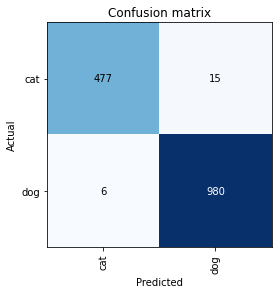

In [16]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [35]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cat       0.99      0.97      0.98       492
         dog       0.98      0.99      0.99       986

    accuracy                           0.99      1478
   macro avg       0.99      0.98      0.98      1478
weighted avg       0.99      0.99      0.99      1478



---

### $\theta=0.1$

#### 1st 

In [15]:
files

(#7390) [Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Sphynx_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/British_Shorthair_203.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Ragdoll_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Persian_272.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/Bombay_200.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/shiba_inu_103.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/chihuahua_142.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/scottish_terrier_156.jpg'),Path('/home/khy/.fastai/data/oxford-iiit-pet/images/basset_hound_163.jpg')...]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

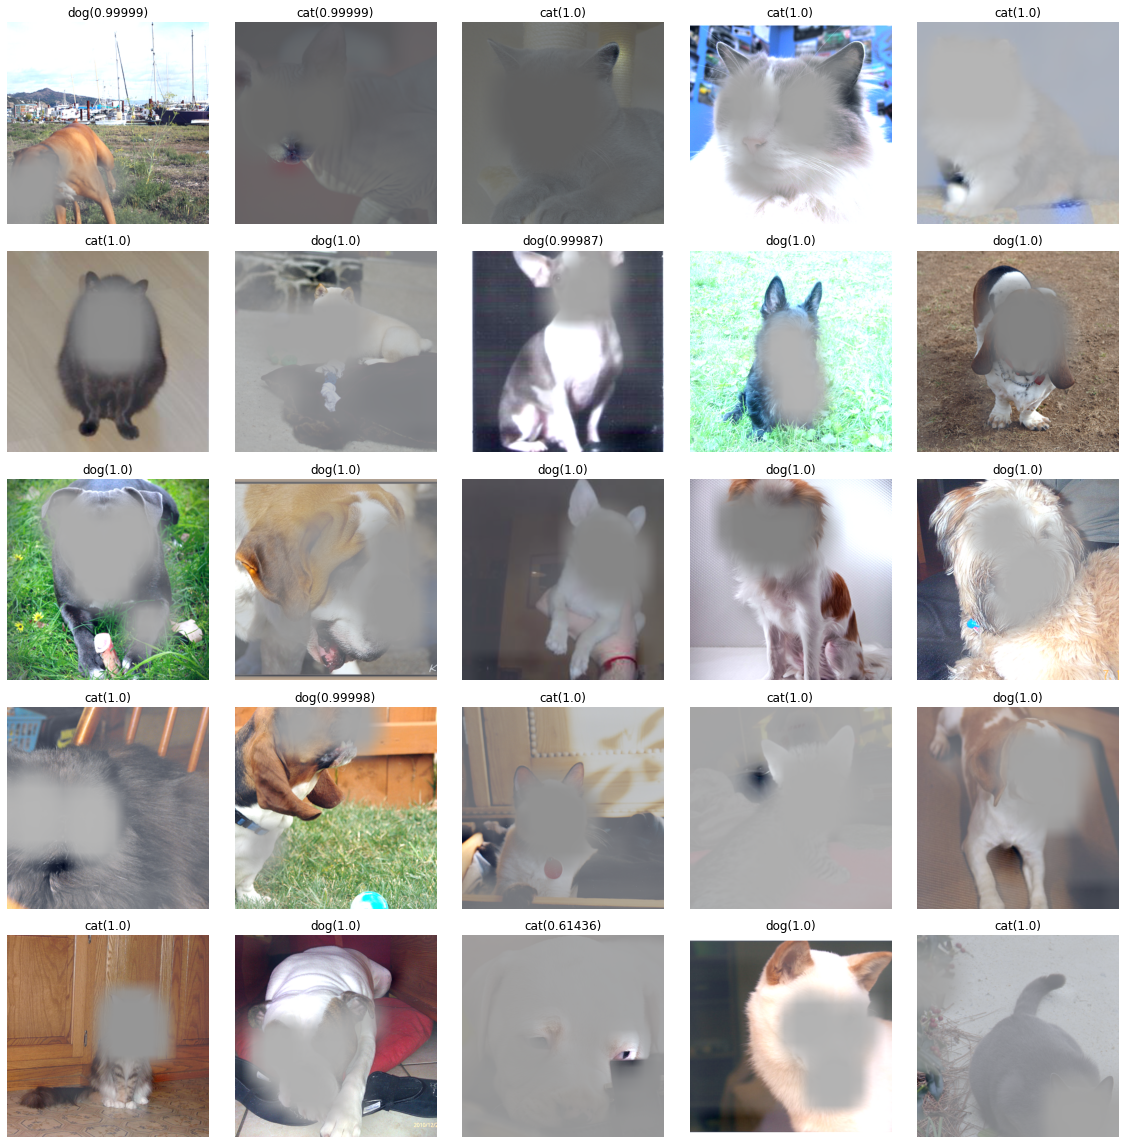

In [16]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if catprob>dogprob: 
            test=camimg[0]-torch.min(camimg[0])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            test=camimg[1]-torch.min(camimg[1])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

----

💡 MODE들을 CAT/DOG 폴더에 저장한다 $\to$ 사진을 불러온다(dls) $\to$ epoc=15로 학습한다(learner) $\to$ accuracy를 확인한다 $\to$ 값을 저장한다 $\to$ 총 100번 수행한 후 평균을 추출한다.

### $\theta=0.01$

In [70]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[1])]))
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
a,b = net(x).tolist()[0]
catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
if catprob>dogprob:
    test=camimg[0]-torch.min(camimg[0])
    A1=torch.exp(-0.01*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
else : 
    test=camimg[1]-torch.min(camimg[1])
    A1=torch.exp(-0.01*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

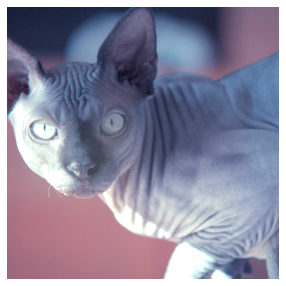

In [71]:
(x1*0.35).squeeze().show()

In [73]:
lrnr2.predict(x1)

('cat', tensor(0), tensor([0.9565, 0.0435]))

In [74]:
??ImageDataLoaders.from_lists

Signature:
ImageDataLoaders.from_lists(
    path,
    fnames,
    labels,
    valid_pct=0.2,
    seed: int = None,
    y_block=None,
    item_tfms=None,
    batch_tfms=None,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None,
)
Source:   
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels, valid_pct=0.2, seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        "Create from list of `fnames` and `labels` in `path`"
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock.from_columns(blocks=(ImageBlock, y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock

In [55]:
x1=x1.reshape(1,3,512,512)

In [28]:
net1.to('cpu')
net2.to('cpu')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


---

In [81]:
a = []    # 빈 리스트 생성
 
for i in range(10):
    a.append(0)    # append로 요소 추가
 
print(a)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [92]:
a = []
for i in range(5) : 
    x, = first(dls.test_dl([PILImage.create(get_image_files(path)[i])]))
    camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
    a,b = net(x).tolist()[0]
    catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
    if catprob>dogprob:
        test=camimg[0]-torch.min(camimg[0])
        A1=torch.exp(-0.01*test)
        X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
        Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
        x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
        a
    else : 
        test=camimg[1]-torch.min(camimg[1])
        A1=torch.exp(-0.01*test)
        X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
        Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
        x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
        a[i]=x1

TypeError: 'float' object does not support item assignment

----

## **이미지 위에 그림그리기**

ref.   
https://yunwoong.tistory.com/71  
https://nomalcy.tistory.com/34  
https://www.geeksforgeeks.org/python-pil-imagedraw-draw-rectangle/  
https://stackoverflow.com/questions/16373425/add-text-on-image-using-pil

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont

### **SAMPLE**

In [211]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

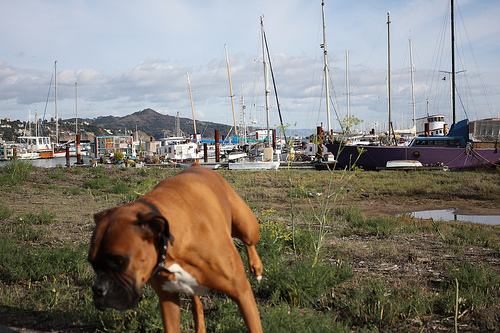

In [212]:
img = PILImage.create(get_image_files(path)[0])
img

In [213]:
x, = first(dls.test_dl([img]))

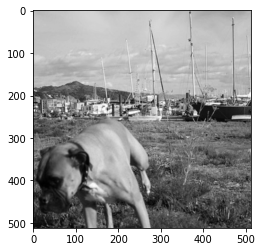

In [214]:
plt.imshow(x.squeeze().to('cpu')[0], cmap="gray")
plt.show()

In [215]:
img.shape

(333, 500)

#### box넣기

In [216]:
(w, h) = (img.shape[0], img.shape[1])
a=(w-512)*0.5
b=(h-512)*0.5
shape = [(a,b),(a+100,b+50)]

<AxesSubplot:>

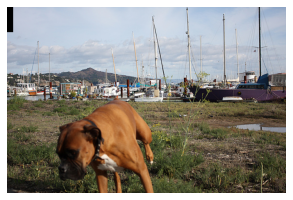

In [217]:
img1 = ImageDraw.Draw(img)  
img1.rectangle(shape, fill ="black", outline ="black")
img.show()

#### text넣기

In [218]:
font = ImageFont.truetype("DejaVuSans.ttf", round(h
                                                  *0.08))

<AxesSubplot:>

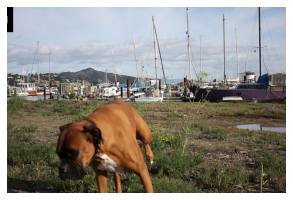

In [219]:
ImageDraw.Draw(img).text((a,b), 'DOG', (255, 255, 255), font=font)
img.show()

<AxesSubplot:>

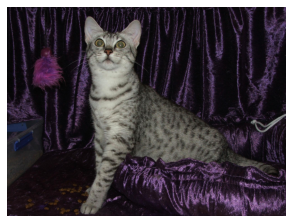

In [205]:
img = PILImage.create(get_image_files(path)[3000])
img.show()

In [210]:
img.shape

(1499, 1999)

In [208]:
x, = first(dls.test_dl([img]))

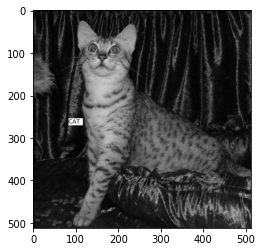

In [209]:
plt.imshow(x.squeeze().to('cpu')[0], cmap="gray")
plt.show()

In [206]:
(w, h) = (img.shape[0], img.shape[1])
a=(w-512)*0.5
b=(h-512)*0.5
shape = [(a,b),(a+100,b+50)]
#shape = [(30, 30), (130, 80)]

<AxesSubplot:>

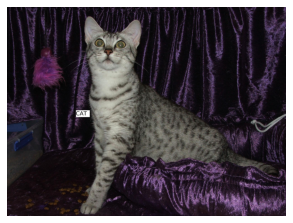

In [207]:
img1 = ImageDraw.Draw(img)  
img1.rectangle(shape, fill ="white", outline ="black")
ImageDraw.Draw(img).text((a, b), 'CAT', (0,0,0), font=font)
img.show()

### **전체 적용하기**

In [ ]:
a=str(list(path.ls())[1]).split('/')[-1]

In [ ]:
a.isupper()

False

In [ ]:
print(str(list(path.ls())[1]).split('/')[-1][0].isupper())
print(str(list(path.ls())[0]).split('/')[-1][0].isupper())

True
False


In [ ]:
str(list(path.ls())[0]).isupper()

False

In [64]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

In [224]:
dls.vocab

['cat', 'dog']

---

In [220]:
path=untar_data(URLs.PETS)/'images'

In [221]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [222]:
files=get_image_files(path)

In [223]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [224]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

AttributeError: ls

In [236]:
for i in range(7393) :
    img = PILImage.create(get_image_files(path)[i])
    img = img.resize([512,512], resample=None, box=None, reducing_gap=None)
    (w, h) = (img.shape[0], img.shape[1])
    shape = [(0, 0), (w*0.3, h*0.1)]
    font = ImageFont.truetype("DejaVuSans.ttf", round(h*0.08))
    name=str(list(path.ls())[i]).split('/')[-1]
    if name[0].isupper() == True :
        img1 = ImageDraw.Draw(img)  
        img1.rectangle(shape, fill ="white", outline ="black")
        ImageDraw.Draw(img).text((5, 0), 'CAT', (0,0,0), font=font)
        img.save("pet2/"+name, 'png')
    else: 
        img1 = ImageDraw.Draw(img)  
        img1.rectangle(shape, fill ="black", outline ="black")
        ImageDraw.Draw(img).text((5, 0), 'DOG', (255,255,255), font=font)
        img.save("pet2/"+name, 'png')

IndexError: list index out of range

---

In [237]:
path2=Path('pet2') 

In [238]:
path2.ls()

(#7391) [Path('pet2/boxer_128.jpg'),Path('pet2/Sphynx_142.jpg'),Path('pet2/British_Shorthair_203.jpg'),Path('pet2/Ragdoll_142.jpg'),Path('pet2/Persian_272.jpg'),Path('pet2/Bombay_200.jpg'),Path('pet2/shiba_inu_103.jpg'),Path('pet2/chihuahua_142.jpg'),Path('pet2/scottish_terrier_156.jpg'),Path('pet2/basset_hound_163.jpg')...]

In [239]:
files=get_image_files(path2)

In [240]:
dls2=ImageDataLoaders.from_name_func(path2,files,label_func,item_tfms=Resize(512)) 

In [241]:
lrnr3=cnn_learner(dls2,resnet34,metrics=error_rate)
lrnr3.fine_tune(1)

In [242]:
net3=lrnr3.model[0]
net4=lrnr3.model[1] 

In [243]:
net4 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [244]:
net_new=torch.nn.Sequential(net3,net4)

In [245]:
lrnr4=Learner(dls2,net_new,metrics=accuracy) 

In [246]:
lrnr4.fine_tune(10) 

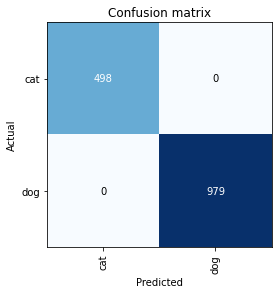

In [247]:
interp = ClassificationInterpretation.from_learner(lrnr4)
interp.plot_confusion_matrix()

In [248]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       498
         dog       1.00      1.00      1.00       979

    accuracy                           1.00      1477
   macro avg       1.00      1.00      1.00      1477
weighted avg       1.00      1.00      1.00      1477



In [250]:
x, = first(dls2.test_dl([PILImage.create(get_image_files(path2)[3000])]))

In [251]:
camimg = torch.einsum('ij,jkl -> ikl', net4[2].weight, net3(x).squeeze())

In [255]:
x.shape

torch.Size([1, 3, 512, 512])

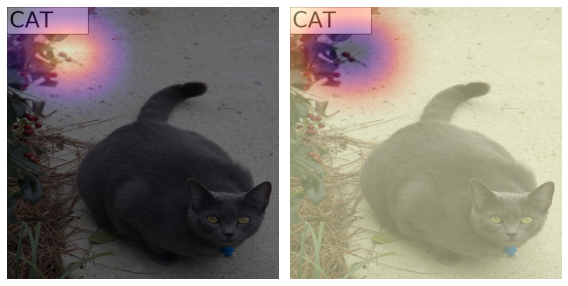

In [254]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls2.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,512,512,0),interpolation='bilinear',cmap='magma')
#
dls2.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,512,512,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

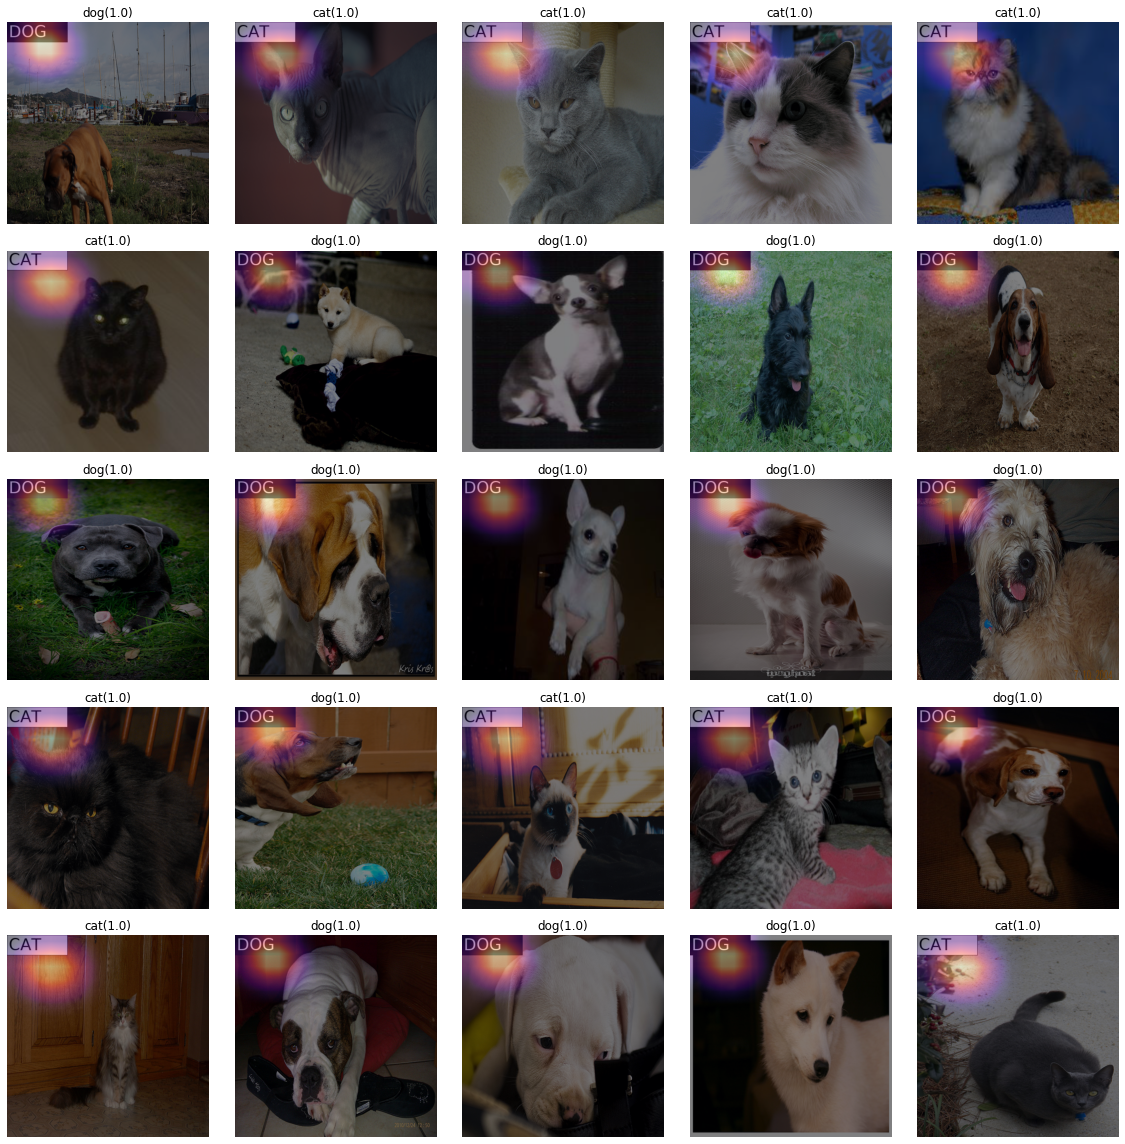

In [256]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls2.test_dl([PILImage.create(get_image_files(path2)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net4[2].weight, net3(x).squeeze())
        a,b = net_new(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if catprob>dogprob: 
            dls2.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            dls2.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [266]:
x, = first(dls2.test_dl([PILImage.create(get_image_files(path2)[1])]))
camimg = torch.einsum('ij,jkl -> ikl', net4[2].weight, net3(x).squeeze())
a,b = net_new(x).tolist()[0]
catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
if catprob>dogprob:
    test=camimg[0]-torch.min(camimg[0])
    A1=torch.exp(-0.2*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
else : 
    test=camimg[1]-torch.min(camimg[1])
    A1=torch.exp(-0.2*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

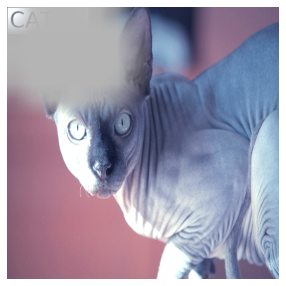

In [267]:
(x1*0.35).squeeze().show()

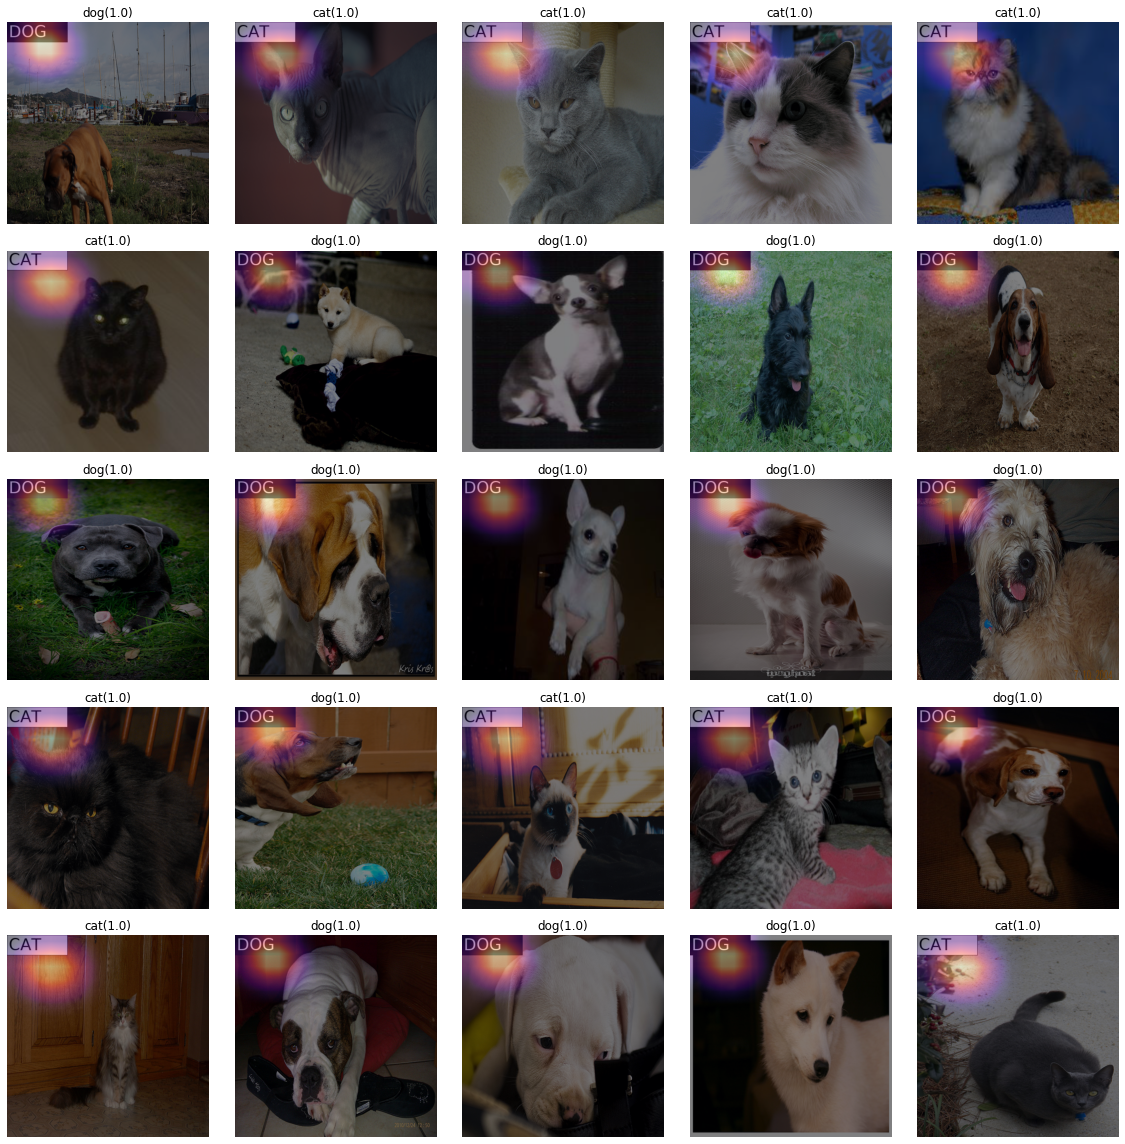

In [256]:
x, = first(dls2.test_dl([PILImage.create(get_image_files(path2)[1])]))
camimg = torch.einsum('ij,jkl -> ikl', net4[2].weight, net3(x).squeeze())
a,b = net_new(x).tolist()[0]
catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
if catprob>dogprob:
    test=camimg[0]-torch.min(camimg[0])
    A1=torch.exp(-0.2*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
else : 
    test=camimg[1]-torch.min(camimg[1])
    A1=torch.exp(-0.2*test)
    X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
    Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
    x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)